# EEG Pre-Processing Template

In [1]:
# Load dependencies
import pandas as pd
import numpy as np
import mne
import pyprep

import preprocessing

## Load and prepare the recording file

In [2]:
# Load data from .txt file
# TODO
# Convert data into pandas DataFrame with electrode channels as columns
# TODO

# Set correct channel names
# You could use this if there are no other columns (the order of the elec names is correct): 
eeg_list = ['time', 'L1', 'L2', 'L3', 'L4', 'L7', 'L8', 'L9', 'L10', 'R1', 'R2', 'R3', 'R5', 'R7', 'R8', 'R9', 'R10']
# TODO

In [3]:
# from pathlib import Path
# import pandas

# def _reader(fname):
#     return pandas.read_csv(fname, sep=',', header=[0])

# folder = Path("eeg_data")
# df = pandas.concat([
#     _reader(txt)
#     for txt in folder.glob("*.txt")
# ])
# df
df_lukas = pd.read_csv('eeg_data/Lukas.txt',header=[0],sep=',')
df_david = pd.read_csv('eeg_data/David.txt', header=[0], sep=',')

org_dfs = [df_lukas, df_david]

In [4]:
#list with relevent columns
rel_columns = [' Timestamp', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', 
                ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10', 
                ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13', ' EXG Channel 14', ' EXG Channel 15']
#select relevent columns for both routines
prepared_lukas = df_lukas[rel_columns]
eeg_lukas = prepared_lukas.set_axis(eeg_list, axis=1, inplace=False)

prepared_david = df_david[rel_columns]
eeg_david = prepared_david.set_axis(eeg_list, axis=1, inplace=False)

In [5]:
eeg_david.head(3)
print(eeg_david.shape)
print(eeg_lukas.shape)

eeg_list = [eeg_lukas, eeg_david]

(202925, 17)
(213438, 17)


<AxesSubplot:xlabel='time'>

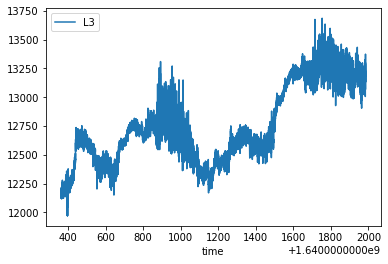

In [6]:
eeg_david.plot(y="L3", x="time")

## Preprocess (clean) the signals

Creating RawArray with float64 data, n_channels=16, n_times=202925
    Range : 0 ... 202924 =      0.000 ...  1623.392 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.49 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 62.50 Hz)
- Filter length: 41251 samples (330.008 sec)

Using matplotlib as 2D backend.


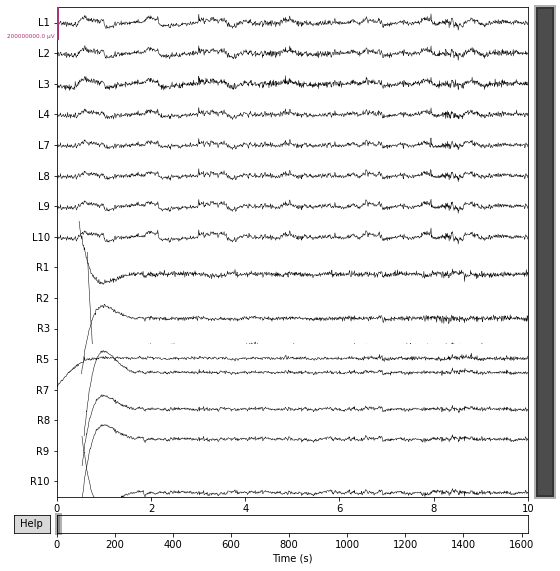

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 825 samples (6.600 sec)



/var/folders/nd/1c96p1j541lbj3jy8jxklgb00000gn/T/ipykernel_20927/2238694674.py:15: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw = raw.copy().set_montage(ceegrid_montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.49 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 62.50 Hz)
- Filter length: 41251 samples (330.008 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)



KeyboardInterrupt: 

In [7]:
# %matplotlib qt

# Load EEG data into MNE Python for preprocessing
# Create MNE Python object
fs = 125 # Sampling frequency of the OpenBCI recording
ch_names = eeg_david.drop('time', axis=1).columns.values.tolist()
info = mne.create_info(ch_names, fs, ch_types='eeg')
raw = mne.io.RawArray(np.array(eeg_david.drop('time', axis = 1)).transpose(), info)

# High-Pass Filter & Plot for visual inspection
raw.copy().filter(l_freq = 1, h_freq = 62.49).plot(scalings=dict(eeg=100))

# Load custom montage (for cEEGrids) - these are the coordinates of the electrodes on the head
ceegrid_montage = mne.channels.read_custom_montage('ceegrid_sph.txt')
raw = raw.copy().set_montage(ceegrid_montage)

# Filter the data
raw = raw.notch_filter(freqs=(25, 50)) # Notch filter to remove power line noise
raw = raw.filter(l_freq = 1, h_freq = 62.49) # 1 Hz Highpass (detrend) & 62.5 Hz Lowpass (remove high-frequency artefacts)

# Detect (& interpolate) bad channels
# You can play around with this a bit if you like - it could also perform poorly in your experiment (the facial muscle artefacts are what you are interested in and should not necessarily be removed...)
raw.info['bads'] = []
nc = pyprep.NoisyChannels(raw, do_detrend=True, random_state=42)
nc.find_bad_by_SNR()
nc.find_bad_by_deviation()
nc.find_bad_by_hfnoise()
nc.find_bad_by_nan_flat()
nc.find_bad_by_ransac()
raw.info['bads'] = nc.get_bads()
# Interpolation can be done using mne python's interpolate_bads()
raw = raw.interpolate_bads()

In [ ]:
columns = raw.ch_names
print(columns)

In [ ]:
cleaned_mne_objects = []

for df in eeg_list:
    cleaned_object = preprocessing.clean_signals(df)
    cleaned_mne_objects.append(cleaned_object)

## Cut the data

In [ ]:
# Here you need to figure out now, how to extract the data per experiment condition/phase, 
# that you would like to extract features for; 
# Your goal is to get timestamps for when a part of the experiment started and when it ended.
list_dfs_with_timestamps = []
# Some information that you might need here
# - You can use raw.get_data() to get to the cleaned signals and raw.times to get the now relative timestamps
# - You can also combine raw.get_data() with your original timestamps that you have in the .txt file
for df, old_df in zip(cleaned_mne_objects, org_dfs):
    temp = pd.DataFrame(df.get_data())
    temp = temp.transpose()
    temp[" Timestamp (Formatted)"] =  old_df[" Timestamp (Formatted)"]

    list_dfs_with_timestamps.append(temp)
#temp_david = pd.DataFrame(raw.get_data())
#temp_david = temp_david.transpose()
#temp_david[" Timestamp (Formatted)"] = df_david[" Timestamp (Formatted)"]
#temp_david.head(3)

In [ ]:
connected_df = list_dfs_with_timestamps[0].append(list_dfs_with_timestamps[1], ignore_index=True)


In [ ]:
#extract the single activities from the full routine
import slicing
experiment_data = slicing.import_experiment_data()
sensor_data = slicing.convert_timestamps(connected_df)
routines = slicing.get_routine_times(experiment_data)
routines_data_dict = slicing.slice_data(routines, sensor_data)

In [ ]:
dkd = routines_data_dict["yawning"][0]
dkd.head()

In [ ]:
def split_given_size(a, size):
   return np.split(a, np.arange(size, a.shape[1], size), axis=1)

In [ ]:
def cut_epochs_1s(array):
    #split data along axis=1
    array_list = split_given_size(array, 125)
    #drop last split if it contains less than 100 values
    if (array_list[-1].shape[1]) < 100:
        del array_list[-1]

    return array_list

In [ ]:
import mne_features.univariate as mf
import eeglib.features as ef

In [ ]:


print(ef.hjorthActivity(ica_dev[0]))

hp_feat = np.apply_along_axis(ef.hjorthActivity, axis = 1, arr = ica_dev[0])
print(hp_feat.shape)

In [ ]:
def calculate_featuresF1(splits):

    features_one_routine = list()
    for epoch in splits:
        #forcing float
        epoch = epoch.astype(float)
        #calc sum
        summe = epoch.sum(axis=1)
        #calc max
        maxi = epoch.max(axis=1)
        #calc Hurst exponent
        hurst = mf.compute_hurst_exp(epoch)
        #calc Petrosian (katz) Frac
        petro = np.apply_along_axis(ef.PFD, axis = 1, arr = epoch)
        #calc Higuchi Fraction
        higuchi = mf.compute_higuchi_fd(epoch)
        #calc Hjorth paramers (Activity, Mobility and Complexity)
        
        acti = np.apply_along_axis(ef.hjorthActivity, axis = 1, arr = epoch)
        compl = mf.compute_hjorth_complexity(epoch)
        mobil = mf.compute_hjorth_mobility(epoch)
        #freq bandpowers
        #theta, alpha, beta = calculate_freq_bandpowers(epoch)

        feature = np.concatenate((summe, maxi, hurst, petro, higuchi, acti, compl, mobil), axis=0)
        #theta, alpha, beta
        #print(feature.shape)
        features_one_routine.append(feature)


    return features_one_routine
 


In [ ]:
test_var = routines_data_dict["yawning"][0].transpose().iloc[:-1:].to_numpy()

epochs_dev = cut_epochs_1s(test_var)

print(epochs_dev[0].shape)
print(epochs_dev[1].shape)
print(epochs_dev[2].shape)

In [ ]:
ica_dev = calculate_ica(3, epochs_dev)

In [ ]:
ica_dev[0].shape

In [ ]:
from sklearn.decomposition import FastICA

def calculate_ica(components, splits):
    return_list = list()

    for epoch in splits:
        #print(epoch.shape)
        epoch_trans = epoch.transpose()
        #print(epoch.shape)
        transformer = FastICA(n_components = components, random_state = 42)

        splits_ica = transformer.fit_transform(epoch_trans)
        splits_ica = splits_ica.transpose()
        print("Shape after ICA is applied: " + str(splits_ica.shape))
        
        concat_array = np.concatenate((epoch, splits_ica), axis = 0)
        return_list.append(concat_array)

    return return_list



In [ ]:
def generate_featureSet2(data = dict, ica_n = int):
    target_list = list()
    everything = list()

    for key, value in data.items():
        for df in value:

            transposed_df = df.transpose()
            feature_data = transposed_df.iloc[:-1:]
            array = feature_data.to_numpy()
            epochs = cut_epochs_1s(array)
            epochs = calculate_ica(components = ica_n, splits = epochs)
            feature = calculate_featuresF1(epochs)
            for zeile in feature:
                everything.append(zeile)
                target_list.append(key)


    training_data = pd.DataFrame(everything)
    training_data['Y'] = target_list

    print(training_data.shape)

    return training_data

In [ ]:
target_list = list()
everything = list()

for key, value in routines_data_dict.items():
    for df in value:

        transposed_df = df.transpose()
        feature_data = transposed_df.iloc[:-1:]
        array = feature_data.to_numpy()
        epochs = cut_epochs_1s(array)
        feature = calculate_featuresF1(epochs)
        for zeile in feature:
            everything.append(zeile)
            target_list.append(key)


training_data = pd.DataFrame(everything)
training_data['Y'] = target_list

print(training_data.shape)


In [ ]:
featureset2 = generate_featureSet2(data = routines_data_dict, ica_n = 3)

In [ ]:
print(training_data.shape)
print(featureset2.shape)



In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

#X = training_data.iloc[:, :-1]
#y = training_data.iloc[:, -1]

def resample(feature_set):
    X = feature_set.iloc[:, :-1]
    y = feature_set.iloc[:, -1]

    sm = SMOTE(random_state = 42)

    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    X_res['Y'] = y_res
    
    return X_res

In [ ]:
#res_data1 = resample(training_data)
res_data2 = resample(featureset2)

#print(res_data1.shape)
print(res_data2.shape)

In [ ]:
# saving to pickle
path_res = './data/resampled/'
path_org = './data/org_sets/'

#res_data1.to_pickle(path = path_res + 'featureSet1.pkl')
res_data2.to_pickle(path = path_res + 'featureSet2.pkl')

#training_data.to_pickle(path = path_org + "featureSet1.pkl")
featureset2.to_pickle(path = path_org + "featureSet2.pkl")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_dims = (10, 5)
plt.figure(figsize=fig_dims)
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})
chart = sns.histplot(data = training_data['Y'], palette=("Blues_d"))
chart.axes.set_title("Class Distribution", fontsize = 20)
#chart.set_xlabel(fontsize = 1)



None

In [ ]:
def calculate_freq_bandpowers(array):
    # Here is an example of how you could extract frequency band powers (requires a numpy array):
    fs = 125
    ch_names = ['L1', 'L2', 'L3', 'L4', 'L7', 'L8', 'L9', 'L10', 'R1', 'R2', 'R3', 'R5', 'R7', 'R8', 'R9', 'R10']

    epoch_duration_sec = 1
    psds, freqs = mne.time_frequency.psd_array_welch(array, fmin=1, fmax=62.5, n_fft=int(fs*epoch_duration_sec), sfreq = 125, n_per_seg=125)
    #casting from object type to complex type
    psds = psds.astype(complex)
    psds = 10. * np.log10(psds) # db normalization

    psd_simple_welch_df = pd.DataFrame(psds.transpose(), columns=ch_names)
    psd_simple_welch_df['Frequency'] = freqs

    def get_band_power(low_bound, high_bound):
        # Find closest indices of band in frequency vector
        idx_band = np.logical_and(freqs >= low_bound, freqs <= high_bound)
        return psds[:, idx_band].mean(axis=1)

    theta = get_band_power(4, 7)
    alpha = get_band_power(8, 13)
    beta = get_band_power(14, 30)

    return theta, alpha, beta 


## Feature extraction

In [ ]:
# Here you have to first decide how to process the data. There are two initial options:
# - Extract features on moving windows (e.g. extract one feature per electrode 
#   for every 2s of the experiment phase or one per electrode for the entire experiment phase)

# You can see which features we have extraced in our NeuroIS article...
'''
In terms of features, we extracted the sum, maximum, Hurst exponent, Petrosian and Higuchi Fractal Dimension, 
and the Hjorth parameters Activity, Mobility, and Complexity
'''
# Here is an example of how you could extract frequency band powers (requires a numpy array):
epoch_duration_sec = 2
psds, freqs = mne.time_frequency.psd_array_welch(array, fmin=1, fmax=62.5, n_fft=int(fs*epoch_duration_sec), sfreq = 100)
#casting from object type to complex type
psds = psds.astype(complex)
psds = 10. * np.log10(psds) # db normalization

psd_simple_welch_df = pd.DataFrame(psds.transpose(), columns=raw.ch_names)
psd_simple_welch_df['Frequency'] = freqs

def get_band_power(low_bound, high_bound):
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low_bound, freqs <= high_bound)
    return psds[:, idx_band].mean(axis=1)

theta = get_band_power(4, 7)
alpha = get_band_power(8, 13)
beta = get_band_power(14, 30)

In [ ]:
import eeglib

t_hjorth = eeglib.features.hjorthActivity(array)
print(t_hjorth)

## Classifier Training

In [ ]:
from sklearn.model_selection import train_test_split

X = training_data.iloc[:, :-1]
y = training_data.iloc[:, -1]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

model = RandomForestClassifier()

model.fit(X_train, y_train)

print(model.score(X_test, y_test))

In [ ]:
class_names = training_data['Y'].tolist()
class_names = set(class_names)
class_names = list(class_names)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
, max_iter = 500